# <center>Rahmentragwerk</center>
---------------------------------------------------
## Beispiel A
**Gegeben:**
 - Rahmentragwerk mit drei starren Geschossdecken gemäß Skizze
 - Höhe der Geschosse $H$, Biegesteifigkeit aller Stützen $EI$ bzw. $2EI$ im 1. Geschoss
 - Masse der Geschosse $m_1$, $m_2$, $m_3$
 - Dämpfung aller Geschosse mit Dämpfungskonstanten $c_1$, $c_2$, $c_3$
 - Anfangsverschiebung $x_0$ sowie Anfangsgeschwindigkeit $v_0$
 - MATLAB-Skript für ein Rahmentragwerk mit zwei Geschossen

<center>
    <img src="resources/rahmentragwerk.png" alt="Rahmentragwerk mit 3 Geschossen Skizze">
</center>

**Gesucht:**
1) Überarbeitung des zur Verfügung gestellten Skripts: Das zwei-geschossige Rahmentragwerk soll auf ein drei-geschossiges Rahmentragwerk erweitert werden. Für die Masse des zusätzlichen Geschosses $m_3$ gilt: $m_3 = \frac{m_2}{2}$
2) Normierte Werte der 1. Eigenform $\varPhi_{1,j}$
3) Maximale (Absolut-)Werte der Verschiebungen $x_{j,max}$

| Freiheitsgrad $j$ | EF $\varPhi$<sub>1,j</sub> \[-\] | x<sub>j,max</sub> \[m\] |
|-------------------------------|-------------------------------------------------|------------------------------|
| 1                             |                                             |                          |
| 2                             |                                             |                          |
| 3                             | 1,00                                            |                          |

*Hinweis:* Äquivalente Federsteifigkeit einer Einzelstütze $k_G = 3 \cdot \frac{EI}{H^3}$ bei gelenkig-eingespannter Lagerung bzw. $k_E = 12 \cdot \frac{EI}{H^3}$ bei beidseitig eingespannter Lagerung.

In [1]:
% Skript zur dynamischen Berechnung eines Rahmens mit bis zu drei
% Geschossen infolge Anfangsverschiebungen und/oder -geschwindigkeiten
%
% Version v1.0, 25.04.2023
% E212-03, FoB Baumechanik und Baudynamik
% Grundlage ist das Script 'ML_29_1' aus:
% C. Petersen, H. Werkle, Dynamik der Baukonstruktionen
% 2. Auflage, Springer Vieweg, Wiesbaden, 2018
% 
% Ausgabe:
%   - Eigenfrequenzen und -formen inkl. vereinfachter Darstellung
%   - Verschiebung, Geschwindigkeit und Beschleunigung an den
%     Geschossdecken (numerische Integration mit Newmark-Verfahren)
%
% Hinweise:
%   - Höhe und Biegesteifigkeit aller Einzelstützen sind gleich
%   - Als Lagerungsart der Stützen kann zwischen gelenkig-eingespannt und
%     eingespannt-eingespannt gewählt werden
%   - Dämpfung ist in jedem Geschoss vorhanden (ANNAHME: modale Dämpfung)
%
clear; clc; close;

In [2]:
% User Information wird abgefragt, um Eingabewerte zu berechnen
user = getenv('JUPYTERHUB_USER');
if (size(user) <= 0)
    user = '42';
else
    user = user(0);
end

rng(mean(double(user)))

In [3]:
% ---------------------------- EINGABEBLOCK ------------------------------
% RAHMEN
% Masse je Geschoss in [kg]
m1 = randi([10000, 20000]);         % 1. Geschoss
m2 = randi([10000, 20000]);         % 2. Geschoss

% Massenmatrix 
M = [m1 0;
     0 m2];

% Sttzen
H = 5;              % Hhe [m]
EI = 5*10^6;        % Biegesteifigkeit [Nm^2]
                       
% quivalente Federsteifigkeit einer Einzelsttze in [N/m]
kG = 3*EI/H^3;      % Lagerung: gelenkig-eigespannt 
kE = 12*EI/H^3;     % Lagerung: eingespannt-eingespannt

% quivalente Federsteifigkeit je Geschoss
k1 = 4*kG;          % 1. Geschoss
k2 = 2*kE;          % 2. Geschoss   

% Steifigkeitsmatrix
K = [k1+k2  -k2;
      -k2    k2];

% Dmpfung je Geschoss in [Ns/m]
zeta = 0.03;        % Lehr'sches Dmpfungsma [-]

c1 = 2*zeta*sqrt(m1*k1);
c2 = 2*zeta*sqrt(m2*k2);

% Dmpfungsmatrix 
C = [c1+c2  -c2;
      -c2    c2];

% ANFANGSWERTE
x_0 = [0.1 0];     % Anfangsverschiebungen [m]
v_0 = [0 0];       % Anfangsgeschwindigkeiten [m/s] 

% ZEIT
t_ber = 30;          % Berechnungszeit [s]
dt = 0.005;          % Berechnungszeitschritt [s]

In [4]:
% -------------------------- BERECHNUNGSBLOCK ----------------------------
% Lösung Eigenwertproblem
[EF,EW] = eig(K,M); % A-Eigenformmatrix, EW-Eigenwertmatrix

% Definition eines Vektors für die ermittelten Eigenwerte
D_EW = diag(EW);

% Ermittlung der Eigenkreisfrequenzen
Omega = sqrt(D_EW);

% Sortierung der Eigenwerte in aufsteigender Reihenfolge
[Omega,index] = sortrows(Omega);
EF = EF(:,index);

% Ermittlung der Eigenfrequenzen
Freq = Omega/(2*pi);

% Ermittlung der Eigenschwingzeiten
T = 1./Freq;

% Anzahl der Berechnungszeitschritte
nt = ceil(t_ber/dt)+1;
t_int = 0:dt:dt*(nt-1);

In [5]:
% Normierung der Eigenvektoren auf das betragsgrößte Element
n = size(K,1); % Matrixdimension
for j = 1:1:n
    if max(EF(:,j))>abs(min(EF(:,j)))
       z1 = max(EF(:,j));
       for i = 1:1:n
         EF(i,j) = (EF(i,j)/z1);
       end
    else
       z1 = min(EF(:,j));
       for i = 1:1:n
         EF(i,j) = (EF(i,j)/z1);
       end
    end
end

In [6]:
% Definition der Ergebnisvektoren
x = zeros(n,nt);  % Verschiebungsmatrix
v = zeros(n,nt);  % Geschwindigkeitsmatrix
a = zeros(n,nt);  % Beschleunigungsmatrix

% Berücksichtigung der Anfangsbedingungen
for i = 1:1:n
    x(i,1) = x_0(i);
    v(i,1) = v_0(i);
end

count_m0 = 0;  % Zähler der Nulleinträge auf der Diagonale der Massenmatrix
for ii = 1:1:size(M,1)    
    if M(ii,ii) == 0
        count_m0 = count_m0+1;
    end
end
if count_m0 == 0
    a(:,1) = (-M^-1)*(C*v(:,1)+K*x(:,1));
else
    a(:,1) = -pinv(M)*(C*v(:,1)+K*x(:,1));
end

In [7]:
% Integrationsparameter für das Newmark-Verfahren
alpha = 0.5;
beta = 0.25;

% Berechnung der Schwingreaktion mittels Newmark-Verfahren
for i = 2:1:nt
    a_h = ((1/beta)*M)+(alpha/beta)*C*dt+K*dt^2;
    b_h = ((1/beta)*M+(alpha/beta)*C*dt)*x(:,i-1)+((1/beta)*M+...
        (alpha/beta-1)*C*dt)*dt*v(:,i-1)+((1/(2*beta)-1)*M+...
        (alpha/(2*beta)-1)*C*dt)*dt^2*a(:,i-1);
    x(:,i) = a_h^-1*b_h;
    v(:,i) = (alpha/(beta*dt))*(x(:,i)-x(:,i-1))-((alpha/beta)-1)*...
        v(:,i-1)-(alpha/(2*beta)-1)*dt*a(:,i-1);
    a(:,i) = (1/(beta*dt^2))*(x(:,i)-x(:,i-1))-1/(beta*dt)*v(:,i-1)-...
        (1/(2*beta)-1)*a(:,i-1);
end

In [8]:
% Ausgabe der normierten Werte der 1. Eigenform
disp('Normierte Werte der 1. EF:')
disp(append('EF1,1 = ',num2str(EF(1,1))))
switch n
case 3
disp(append('EF1,2 = ',num2str(EF(2,1))))
disp(append('EF1,3 = ',num2str(EF(3,1))))
case 2
disp(append('EF1,2 = ',num2str(EF(2,1))))
end

% Ausgabe der max. (Absolut-)Werte der Verschiebung je Geschoss
disp('Max. (Absolut-)Werte der Verschiebungen:')
disp(append('x1 = ',num2str(round(max(abs(x(1,:))),2)),' m'))
switch n
case 3
disp(append('x2 = ',num2str(round(max(abs(x(2,:))),2)),' m'))
disp(append('x3 = ',num2str(round(max(abs(x(3,:))),2)),' m'))
case 2
disp(append('x2 = ',num2str(round(max(abs(x(2,:))),2)),' m'))
end

Normierte Werte der 1. EF:
EF1,1 = 0.82267
EF1,2 = 1
Max. (Absolut-)Werte der Verschiebungen:
x1 = 0.1 m
x2 = 0.09 m



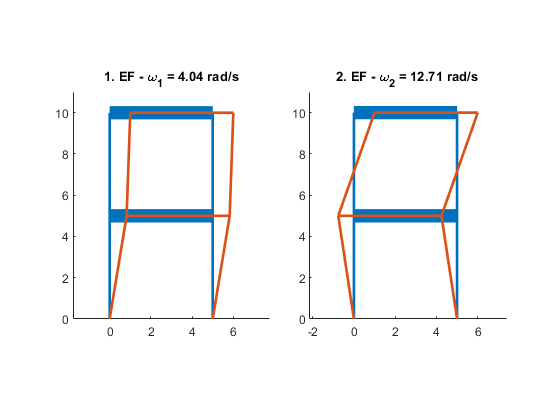

In [9]:
% ------------------------- DARSTELLUNGSBLOCK ----------------------------
% Grafische Darstellung der Ergebnisse
name_fig1 = 'Eigenformen';
fig1 = figure('Name',name_fig1,'NumberTitle','off'); 
set(fig1,'Position',[200 500 1000 500]);
tl_EF = tiledlayout(1,n);
tl_EF.TileSpacing = 'compact'; tl_EF.Padding = 'loose';

% Koordinaten
X = [0 5];
switch n
case 3
    Y = [0 H 2*H 3*H];
case 2
    Y = [0 H 2*H];
case 1
    Y = [0 H];
end

for j = 1:1:n
nexttile

% DARSTELLUNG RAHMEN
% Stützen 1. Geschoss
line([X(1) X(1)],[Y(1) Y(2)],'linewidth',2)
line([X(2) X(2)],[Y(1) Y(2)],'linewidth',2)

% Geschossdecke 1. Geschoss
line([X(1) X(2)],[Y(2) Y(2)],'linewidth',10)

switch n
case 3
    % Stützen 2. Geschoss
    line([X(1) X(1)],[Y(2) Y(3)],'linewidth',2)
    line([X(2) X(2)],[Y(2) Y(3)],'linewidth',2)
    % Stützen 3. Geschoss
    line([X(1) X(1)],[Y(3) Y(4)],'linewidth',2)
    line([X(2) X(2)],[Y(3) Y(4)],'linewidth',2)
    
    % Geschossdecke 2. Geschoss
    line([X(1) X(2)],[Y(3) Y(3)],'linewidth',10)
    % Geschossdecke 3. Geschoss
    line([X(1) X(2)],[Y(4) Y(4)],'linewidth',10)
case 2
    % Stützen 2. Geschoss
    line([X(1) X(1)],[Y(2) Y(3)],'linewidth',2)
    line([X(2) X(2)],[Y(2) Y(3)],'linewidth',2)
    
    % Geschossdecke 2. Geschoss
    line([X(1) X(2)],[Y(3) Y(3)],'linewidth',10)
end
% DARSTELLUNG EIGENFORMEN
% Stützen 1. Geschoss
line([X(1) X(1)+EF(1,j)],[Y(1) Y(2)],'linewidth',2,'color','#D95319')
line([X(2) X(2)+EF(1,j)],[Y(1) Y(2)],'linewidth',2,'color','#D95319')

% Geschossdecke 1. Geschoss
line([X(1)+EF(1,j) X(2)+EF(1,j)],[Y(2) Y(2)],'linewidth',2,'color','#D95319')

switch n
case 3
% Stützen 2. Geschoss    
line([X(1)+EF(1,j) X(1)+EF(2,j)],[Y(2) Y(3)],'linewidth',2,'color','#D95319')
line([X(2)+EF(1,j) X(2)+EF(2,j)],[Y(2) Y(3)],'linewidth',2,'color','#D95319')
% Stützen 3. Geschoss
line([X(1)+EF(2,j) X(1)+EF(3,j)],[Y(3) Y(4)],'linewidth',2,'color','#D95319')
line([X(2)+EF(2,j) X(2)+EF(3,j)],[Y(3) Y(4)],'linewidth',2,'color','#D95319')

% Geschossdecke 2. Geschoss
line([X(1)+EF(2,j) X(2)+EF(2,j)],[Y(3) Y(3)],'linewidth',2,'color','#D95319')
% Geschossdecke 3. Geschoss
line([X(1)+EF(3,j) X(2)+EF(3,j)],[Y(4) Y(4)],'linewidth',2,'color','#D95319')

case 2
% Stützen 2. Geschoss 
line([X(1)+EF(1,j) X(1)+EF(2,j)],[Y(2) Y(3)],'linewidth',2,'color','#D95319')
line([X(2)+EF(1,j) X(2)+EF(2,j)],[Y(2) Y(3)],'linewidth',2,'color','#D95319')

% Geschossdecke 2. Geschoss
line([X(1)+EF(2,j) X(2)+EF(2,j)],[Y(3) Y(3)],'linewidth',2,'color','#D95319')
end

xlim([X(1)-2 X(2)+2]); ylim([0 Y(end)+1])
title(append(num2str(j),'. EF - \omega_',num2str(j),' = ',...
      num2str(round(Omega(j),2)),' rad/s'))
axis equal
end

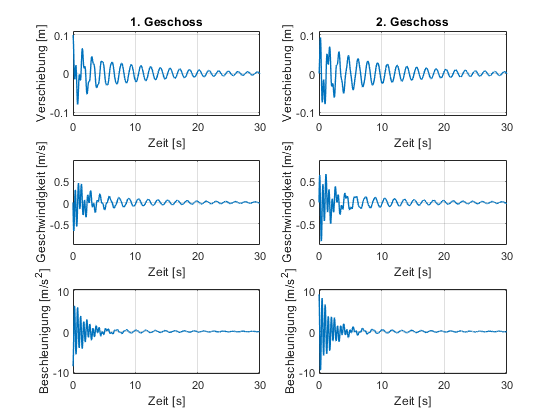

In [10]:
name_fig2 = 'Schwingungsantworten';
fig2 = figure('Name',name_fig2,'NumberTitle','off'); 
set(fig2,'Position',[1300 300 1100 700]);

tl_SA = tiledlayout(3,n);
tl_SA.TileSpacing = 'compact'; tl_SA.Padding = 'loose';

for j = 1:1:n
nexttile
plot(t_int,x(j,:),'MarkerSize',3,'LineWidth',1)
title(append(num2str(j),'. Geschoss'))
xlabel('Zeit [s]')
ylabel('Verschiebung [m]')
ylim([-(max(abs(x),[],'all')*1.1) max(abs(x),[],'all')*1.1])
grid on
end

for j = 1:1:n
nexttile
plot(t_int,v(j,:),'MarkerSize',3,'LineWidth',1)
xlabel('Zeit [s]')
ylabel('Geschwindigkeit [m/s]')
ylim([-(max(abs(v),[],'all')*1.1) max(abs(v),[],'all')*1.1])
grid on
end

for j = 1:1:n
nexttile
plot(t_int,a(j,:),'MarkerSize',3,'LineWidth',1)
xlabel('Zeit [s]')
ylabel('Beschleunigung [m/s^2]')
ylim([-(max(abs(a),[],'all')*1.1) max(abs(a),[],'all')*1.1])
grid on
end